<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Stuff" data-toc-modified-id="Import-Stuff-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Stuff</a></span><ul class="toc-item"><li><span><a href="#Anonymous-Functions" data-toc-modified-id="Anonymous-Functions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Anonymous Functions</a></span></li><li><span><a href="#Named-Functions" data-toc-modified-id="Named-Functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Named Functions</a></span></li></ul></li><li><span><a href="#Zeroed-Comparison" data-toc-modified-id="Zeroed-Comparison-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Zeroed Comparison</a></span><ul class="toc-item"><li><span><a href="#Critical-Point-Difference" data-toc-modified-id="Critical-Point-Difference-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Critical Point Difference</a></span></li></ul></li></ul></div>

# Import Stuff

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
pd.options.mode.chained_assignment = None # Suppresses annoying warnings

sns.set(font_scale=1.5)
#sns.set_context("poster")

with open("tidy_data/pmap_finer_resolution_data.pkl","rb") as _filein:
    raw_data = pkl.load(_filein)
    
raw_df = pd.DataFrame(raw_data)
raw_df.fill = raw_df.fill.apply(int)
raw_df.config = raw_df.config.apply(int)
raw_df.head()

,config,coupling,energy,fill
0,39,antiferro,-934.131570,1110
1,16,antiferro,-948.451377,1111
2,34,antiferro,-919.810100,1100
3,30,antiferro,-948.451396,1111
4,21,antiferro,-905.487958,1000


## Anonymous Functions

In [2]:
filter_by_fill = lambda fill, df=raw_df: df[df.fill == fill]


## Named Functions

In [3]:

def zero_energy(fill):
    df = filter_by_fill(fill)
    df.sort_values("config",axis=0,inplace=True)
    zero_en = df.energy.values[0]
    df.energy -= zero_en
    scale = len(df.config)-1
    df.config *= 0.01
    
    return df
def plot_zeroed_comparison():
    fig = plt.figure(figsize=(16,12))
    ax = plt.gca()

    for fill in set(raw_df.fill.values):
        sns.lineplot(x="config",y="energy",data=zero_energy(fill),ax=ax,label="Fill: {}".format(fill))

    ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
    ax.set(xlabel="Rotation Angle [rad]",ylabel="Energy [eV]")
    
    cps = find_critical_points()
    labels = 'A B C D E'.split()
    for cp,label in zip(cps,labels):
        ax.axvline(cp)
        ax.text(cp+0.01,-0.000209,label,fontsize=14)
    


def find_critical_config(_min,_max,critical='max'):
    df = zero_energy(1111)
    mask_min = df.config > _min
    mask_max = df.config < _max
    df = df[mask_min & mask_max]
    #df = df[mask_max]
    critical_energy = df.energy.max() if critical == 'max' else df.energy.min()
    critical_config = float(df[df.energy == critical_energy].config.values)
    return critical_config

def find_critical_points():
    ranges = [(0.,0.1,'max'),(0.2,0.4,'min'),(0.4,0.5,'max'),(0.5,0.6,'min')]
    critical_pts = [0.]
    for i in ranges:
        _min, _max, critical = i
        critical_pts.append(find_critical_config(_min,_max,critical=critical))

    return critical_pts

def get_critical_energies(fill):
    df = zero_energy(fill)
    critical_pts = find_critical_points()
    critical_ens = [float(df[df.config == pt].energy.values) for pt in critical_pts]
    return critical_ens

def get_critical_energy_diffs(fill):
    critical_pts = find_critical_points()
    critical_ens = get_critical_energies(fill)
    diff = [(0,2),(2,4),(0,4)]
    ediffs = [critical_ens[i]-critical_ens[j] for i,j in diff]
    return ediffs

def plot_critical_point_difference():
    fills = list(set(raw_df.fill))
    ediffs = [np.abs(get_critical_energy_diffs(fill))*10**3 for fill in fills]
    ediff_ac = [i[0] for i in ediffs]
    ediff_ce = [i[1] for i in ediffs]
    ediff_ae = [i[2] for i in ediffs]
    fills = [0.25,0.5,0.5,0.75,1.]
    
    xi = np.arange(0.,1.25,0.25)
    m_ac, b_ac, _, _, _ = stats.linregress(fills,ediff_ac)
    fit_ac = m_ac*xi+b_ac
    m_ce, b_ce, _, _, _ = stats.linregress(fills,ediff_ce)
    fit_ce = m_ce*xi+b_ce
    m_ae, b_ae, _, _, _ = stats.linregress(fills,ediff_ae)
    fit_ae = m_ae*xi+b_ae

    fig = plt.figure(figsize=(9,6))
    ax = plt.gca()
    ax.scatter(fills,ediff_ac)#,label='A-C')
    ax.scatter(fills,ediff_ce)#,label='C-E')
    ax.scatter(fills,ediff_ae)#,label='A-E')
    ax.plot(xi,fit_ac,label='A-C')
    ax.plot(xi,fit_ce,label='C-E')
    ax.plot(xi,fit_ae,label='A-E')
    ax.set(xlabel='Fill Factor',ylabel='Absolute Energy Difference [meV]',ylim=[-0.05,0.25])
    ax.legend()

# Zeroed Comparison

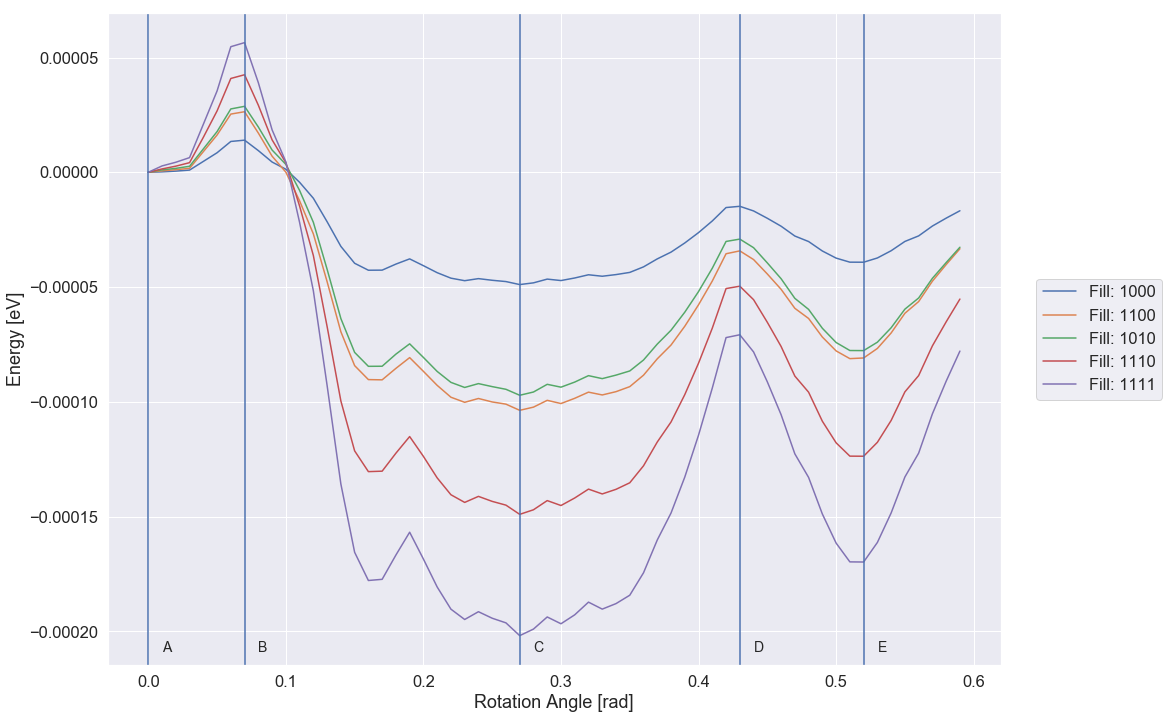

In [4]:

plot_zeroed_comparison()

In [5]:
with open("../difference_analysis/tidy_data/df_fine_sweep.pkl",'wb') as fout:
    pkl.dump(raw_df,fout)

## Critical Point Difference

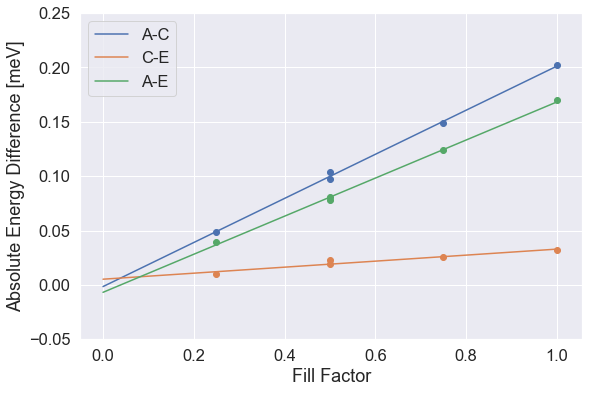

In [6]:
plot_critical_point_difference()

In [7]:
find_critical_points()

[0.0, 0.07, 0.27, 0.43, 0.52]